# Tiempo crítico de despeje de una falta trifásica al comienzo de la línea y que se despeja por apertura de la misma.

In [16]:
# Carga de librerías:
import numpy as np
import cmath as cm
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.optimize as optim

In [5]:
# Datos:
Sgen = 100 # MVA
Ugen = 15 # kV
H = 3 # s
Xgen = 0.3 # pu (transitoria)
Ured = 220 # kV
St = 100 # MVA
Xt = 0.15 # pu
Xl = 0.10 # pu
FPgen = 0.8 # factor de potencia del generador
Gen = 1 # Régimen de carga del generador (tanto por uno)
f = 50 # Hz
omega_0 = 2*np.pi*f # Velocidad de sincronismo

# Transformación a magnitudes por unidad
Sbase = 100 # Potencia base
Ub1 = Ugen # Tensión base zona 1 (generador)
Ub2 = Ured # Tensión base zona 2 (red)
ugen = Ugen/Ub1
ured = Ured/Ub2
sgen = Sgen/Sbase

In [7]:
# Corriente inyectada por el generador antes de la falta:
sgen_comp = sgen*Gen*(FPgen+cm.sin(np.arccos(FPgen))*1j)
igen = sgen_comp/ugen
igen = igen.conjugate()

# Tensión detrás de la reactancia transitoria del generador respecto de los bornes del mismo:
egen = ugen+Xgen*1j*igen 

# Tensión del nodo de conexión a red respecto de los bornes del generador:
ured = ugen-(Xt+Xl)*1j*igen

# Ángulo relativo de la tensión detrás de la reactancia transitoria del generador con relación a la tensión del nudo de potencia infinita ANTES DE LA FALTA:
delta_0 = cm.phase(egen)-cm.phase(ured)

# Cálculo del ángulo crítico de despeje de la falta:
delta_max = np.pi-delta_0
delta_cri = np.arccos(np.sin(delta_0)*(np.pi-2*delta_0)-np.cos(delta_0))

# Cálculo del tiempo crítico de despeje de la falta:
Pacel = sgen_comp.real
tcri = (4*H*(delta_cri-delta_0)/(omega_0*Pacel))**0.5
print('Tiempo crítico de despeje de la falta:',tcri,'s')

Tiempo crítico de despeje de la falta: 0.2285480151819493 s


<IPython.core.display.Javascript object>


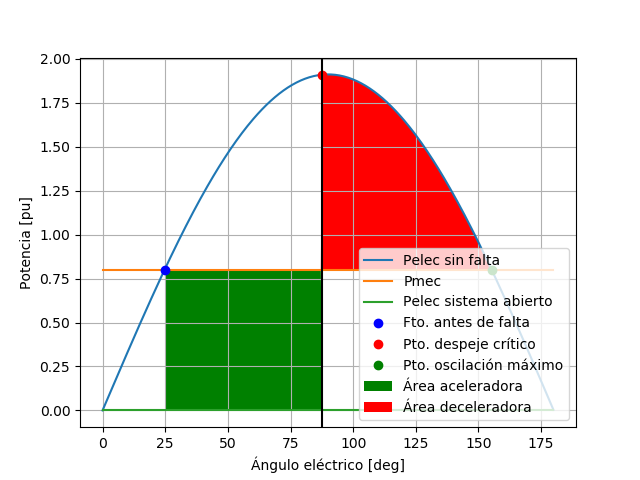

In [4]:
# Potencia transmitida por el sistema:
delta = np.arange(0,np.pi,0.01)
delta_deg = delta*180/np.pi
pelec = abs(egen)*abs(ured)*np.sin(delta)/(Xgen+Xt+Xl)

# Representación gráfica de la curva de potencia eléctrica sin de la falta:
# Interacción dinámica con el gráfico creado.
%matplotlib notebook 
plt.ion() # Activa modo interactivo de dibujo
fpelec = plt.plot(delta_deg, pelec, label = 'Pelec sin falta')
plt.grid() # Malla de la gráfica
plt.ylabel('Potencia [pu]')
plt.xlabel('Ángulo eléctrico [deg]')
plt.ioff() # Desactiva modo interactivo de dibujo

# Representación gráfica de la curva de potencia mecánica:
pmec = sgen_comp.real*np.ones(np.size(delta))
plt.ion() # Activa modo interactivo de dibujo
fpmec = plt.plot(delta_deg, pmec, label = 'Pmec')
plt.ioff() # Desactiva modo interactivo de dibujo

# Representación gráfica de la curva de potencia eléctrica durante el tiempo de despeje de la falta:
pelec2 = np.zeros(np.size(delta))
plt.ion() # Activa modo interactivo de dibujo
fpelec2 = plt.plot(delta_deg, pelec2, label = 'Pelec sistema abierto')
plt.ioff() # Desactiva modo interactivo de dibujo

# Representación gráfica del punto de operación antes de la falta:
p1x = delta_0*180/np.pi
p1y = sgen_comp.real
plt.ion() # Activa modo interactivo de dibujo
p1 = plt.plot([p1x], [p1y], 'bo', label = 'Fto. antes de falta')
plt.ioff() # Desactiva modo interactivo de dibujo

# Representación gráfica del punto de despeje crítico:
p2x = delta_cri*180/np.pi
p2y = abs(egen)*abs(ured)*np.sin(delta_cri)/(Xgen+Xt+Xl)
plt.ion() # Activa modo interactivo de dibujo
p2 = plt.plot([p2x], [p2y], 'ro', label = 'Pto. despeje crítico')
plt.ioff() # Desactiva modo interactivo de dibujo

# Representación gráfica del punto de oscilación máximo:
p3x = delta_max*180/np.pi
p3y = abs(egen)*abs(ured)*np.sin(delta_max)/(Xgen+Xt+Xl)
plt.ion() # Activa modo interactivo de dibujo
p3 = plt.plot([p3x], [p3y], 'go', label = 'Pto. oscilación máximo')
plt.ioff() # Desactiva modo interactivo de dibujo

# Representación gráfica del área aceleradora:
delta_deg2 = np.ma.masked_greater(delta_deg,delta_cri*180/np.pi)
plt.fill_between(delta_deg2, 0, pmec, where = pelec >= pmec, facecolor='green', interpolate=True, label='Área aceleradora')
plt.axvline(x=delta_cri*180/np.pi, color = 'black')

# Representación gráfica del área deceleradora:
delta_deg3 = np.ma.masked_greater(delta_deg, delta_max*180/np.pi)
plt.fill_between(delta_deg3, pmec, pelec, where = delta_deg3 >= delta_cri*180/np.pi, facecolor='red', interpolate=True, label='Área deceleradora')

plt.legend(loc = 'lower right')
#plt.legend(loc = 'upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)

In [15]:
# Cálculo del área aceleradora:
def Pacel(delta,sgen_comp):
    pacel = sgen_comp.real
    return pacel

Aacel = integrate.quad(Pacel, delta_0, delta_cri, args=(sgen_comp))
print('Área aceleradora:',Aacel[0])

# Cálculo del área deceleradora:
def Pdecel(delta,egen,ured,Xgen,Xt,Xl,sgen_comp):
    pdecel = abs(egen)*abs(ured)*np.sin(delta)/(Xgen+Xt+Xl)-sgen_comp.real
    return pdecel

Adecel = integrate.quad(Pdecel, delta_cri, delta_max, args=(egen,ured,Xgen,Xt,Xl,sgen_comp))
print('Área deceleradora:',Adecel[0])

Área aceleradora: 0.8751923415653093
Área deceleradora: 0.8751923415653099


In [91]:
# Función del área aceleradora:
def Aacel(delta_1,delta_2):
    Aacel = integrate.quad(Pacel, delta_1, delta_2, args=(sgen_comp))
    return Aacel[0]

# Función del área deceleradora:
def Adecel(delta_1,delta_2):
    Adecel = integrate.quad(Pdecel, delta_cri, delta_max, args=(egen,ured,Xgen,Xt,Xl,sgen_comp))
    return Adecel[0]

# Función del residuo de la diferencia de áreas:
def IgualdadAreas(delta):
    return (Aacel(delta_0,delta)-Adecel(delta,delta_max))**2

# Comenzamos la optimización: función residuo de la diferencia de áreas mínima:
delta_start = (delta_0+delta_max)/2 # Valor semilla.
bnd_x1 = delta_0 # Límite inferior (restricción).
bnd_x2 = delta_max # Límite superior (restricción).
limites = optim.Bounds(bnd_x1,bnd_x2)
delta_opt = optim.minimize(IgualdadAreas,np.array([delta_start]),method='L-BFGS-B',bounds=limites).x
print('El ángulo crítico calculado es:',delta_opt[0],'rad')

El ángulo crítico calculado es: 1.5257339666089873 rad
El ángulo crítico calculado es: 1.5257339714724203 rad
1.5137910076538026e-17
